# *p*-Adic Signals for $\pmb{\text{GL}_1(\mathbb{Q}_p)}$.

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import tqdm

## Outline.

### Class: `p_Approx`
Approximates a non-zero $p$-adic number up to a given order (modulo the number's norm). An instance of `p_Approx` represents an "order-$m$ unit-truncated" $p$-adic number
$$
a\ =\ p^n\cdot(a_0+a_1 p+a_2 p^2+\cdots+a_m p^m)
$$
Attributes:
 * $\text{uniformizer}(a)=p$
 * $\text{ord}_{p}(a)=n$
 * $\text{resol}_{p}(a)=m$
 * $\text{digits}(a)=(a_0,a_1,\dots,a_m)$
 
 * $\text{unit}=a_0+a_1 p+a_2 p^2+\cdots+a_m p^m$

In [2]:
class p_Approx():
    def __init__(self,
                 p,
                 order,
                 digits):
        
        assert all(isinstance(argument, int) for argument in [p, order])
        assert p>=2
        assert isinstance(digits, list), 'The argument \"digits\" must be a list of integers.'
        assert all(isinstance(d, int) and 0<=d<p for d in digits), 'All digits must be between 0 and p-1.'
        assert (len(digits)>1 and digits[0]!= 0) or order==0, 'The p-adic number \"0\" can only be represented with order 0 and digits [0].'
        # I need to think more carefully about how to incorporate p-adic 0.
        
        self.uniformizer = p
        self.ord_p = order
        self.resol_p = len(digits)
        self.digits = digits
        
        self.unit = sum([d*p**i for i, d in enumerate(digits)])

#### Testing:

In [3]:
A = p_Approx(7, -5, [1, 2, 6])
print('Associated unit (as integer):', A.unit)
print('Check that unit is correct:', A.unit == 1+2*7+6*7**2)

Associated unit (as integer): 309
Check that unit is correct: True


In [4]:
B = p_Approx(7, 0, [0])
print(B.unit)

0


### Function: `to_p_approx`
Takes an integer $x$ (possibly negative) and a specified conductor $m$ and returns the $p$-adic approximation $p^n u$ of $x$ with unit $u$ approximated up to order $m$.  

In [5]:
def to_p_approx(p: int, x: int, m: int) -> p_Approx:
    assert isinstance(p, int) and p>=2
    assert isinstance(x, int)
    assert isinstance(m, int) and m>=0
    
    order = 0
    while x%(p**order)==0:
        order += 1
    order -= 1
    
    unit = int(x/(p**order))
    
    running_unit = copy.deepcopy(unit)
    digits = []
    k=0
    while len(digits) < m+1:
        d = running_unit%p
        digits.append(d)
        running_unit = running_unit - d
        running_unit = int(running_unit/p)
        k += 1
    
    return p_Approx(p, order, digits)

#### Testing:

In [6]:
A = to_p_approx(7, 49*3, 1)
print('Uniformizer:', A.uniformizer)
print('p-Adic order:', A.ord_p)
print('p-Adic resolution for unit factor:', A.resol_p)
print('p-Adic digits:', A.digits)
print('p-Adic unit factor:', A.unit)

Uniformizer: 7
p-Adic order: 2
p-Adic resolution for unit factor: 2
p-Adic digits: [3, 0]
p-Adic unit factor: 3


In [7]:
A = to_p_approx(7, 49*48, 1)
print('Uniformizer:', A.uniformizer)
print('p-Adic order:', A.ord_p)
print('p-Adic resolution for unit factor:', A.resol_p)
print('p-Adic digits:', A.digits)
print('p-Adic unit factor:', A.unit)

Uniformizer: 7
p-Adic order: 2
p-Adic resolution for unit factor: 2
p-Adic digits: [6, 6]
p-Adic unit factor: 48


In [8]:
A = to_p_approx(3, -1, 10)
print('Uniformizer:', A.uniformizer)
print('p-Adic order:', A.ord_p)
print('p-Adic resolution for unit factor:', A.resol_p)
print('p-Adic digits:', A.digits)
print('p-Adic unit factor:', A.unit)

Uniformizer: 3
p-Adic order: 0
p-Adic resolution for unit factor: 11
p-Adic digits: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
p-Adic unit factor: 177146


### Function: `p_mult`
Multiplies two instances of `p_Approx`, returning a new instance of `p_Approx` with resolution the coarser of the respective resolutions of the two p-adic approximations.

In [9]:
def p_mult(x,y):
    assert isinstance(x, p_Approx)
    assert isinstance(y, p_Approx)
    assert x.uniformizer == y.uniformizer
    
    p = x.uniformizer
    
    order = x.ord_p + y.ord_p
    unit = x.unit * y.unit
    
    resolution = min(x.resol_p, y.resol_p)
    
    output = to_p_approx(p, unit, resolution)
    output.ord_p += order
    
    return output

#### Testing:

In [10]:
x = p_Approx(5, 2, [1, 2, 3])
y = p_Approx(5, -2, [2, 0, 3, 2, 2])

print('Unit of x:', x.unit)
print('Unit of y:', y.unit)

z = p_mult(x, y)

print('\nUniformizer of the product:', z.uniformizer)
print('Order of the product:', z.ord_p)
print('Resolution of the product:', z.resol_p)
print('Digits of the product:', z.digits)
print('Unit of the product:', z.unit)

Unit of x: 86
Unit of y: 1577

Uniformizer of the product: 5
Order of the product: 0
Resolution of the product: 4
Digits of the product: [2, 4, 4, 4]
Unit of the product: 622


### Class: `cslcFunc`
Encodes a compactly supported locally constant function $f$ on $\text{GL}_{1}(\mathbb{Q}_p)$, with conductor $m$, by encoding the cofficients $c_i$ and the dilated-and-translated supporting disks $a_i\cdot(1+p^m\mathbb{Z}_p)$ that define the presentation
    $$
    f(x)
    \ =\ 
    \sum_{i=1}^{k}c_i \cdot \mathbb{1}_{a_i\cdot(1+p^m\mathbb{Z}_{\!p})}(x),
    $$
for disk centers $a_i\in\mathbb{Z}/p^m\mathbb{Z}$ and complex numbers $c_i\in\mathbb{C}$. Note that the supporting disk $a_i\cdot(1+p^m\mathbb{Z}_p)$ has radius $\frac{|a_i|_p}{p^{-m}}$, but that *all supporting disks have the same Haar measure*. Observe here that if
    $$
    a_i
    \ =\ 
    p^n\ (a_{i0}+a_{i1}p+\cdots+a_{ik}p^k),
    $$
for $n\in\mathbb{Z}$ and $k\in\mathbb{Z}_{\ge0}$, then we can rewrite $a_{i}\ (1+p^m\mathbb{Z}_{p})$ as
    $$
    a_{i}\ (1+p^m\mathbb{Z}_{p})
    \ \ =\ \ 
    a_{i0}p^n+a_{i1}p^{n+1}+\cdots+a_{ik}p^{n+k}+p^{n+m}\mathbb{Z}_p.
    $$
Consequently, it only makes sense to choose $a_i\in\mathbb{Q}^\times_p$ with resolution $m$, i.e., such that $k=m-1$. In terms of our class `p_Approx`, this means that `a_i.resol_p` should be $m$.

Attributes:
 * $\text{cond}_p(f)=m$
 * $\text{term_dict}=\{\}$
 
Methods:
 * Contravariant multiplication $f(x)\mapsto f(a^{-1}x)$

In [11]:
class cslcFunc():
    def __init__(self, p, m, supports, values):
        assert isinstance(p, int) and p>=2
        assert isinstance(m, int) and m >= 0
        
        assert isinstance(supports, list)
        assert all(isinstance(a, p_Approx) for a in supports)
        assert all(a.resol_p == m for a in supports)
        
        assert isinstance(values, list)
        assert all(isinstance(c, complex) for c in values)
        
        assert len(supports) == len(values)
        
        self.uniformizer = p
        self.cond_p = m
        self.supp = supports
        self.values = values
        
    def contra_mult(self, b):
        assert isinstance(b, p_Approx)
        assert b.uniformizer == self.uniformizer
        assert b.resol_p == self.cond_p
        
        new_supp = [p_mult(b,a) for a in self.supp]
        self.supp = new_supp

#### Testing:

In [12]:
x = p_Approx(5, 2, [1, 2, 3])
y = p_Approx(5, -2, [2, 0, 3])

f = cslcFunc(5, 3, [x, y], [complex(1,0), complex(1,2)])
print('Uniformizer of f:', f.uniformizer)
print('Conductor of f:', f.cond_p)
print('Supporting disks of f:', f.supp)
print('Values of f:', f.values)

Uniformizer of f: 5
Conductor of f: 3
Supporting disks of f: [<__main__.p_Approx object at 0x7faacaa87a30>, <__main__.p_Approx object at 0x7faacaa87ac0>]
Values of f: [(1+0j), (1+2j)]


In [13]:
x = p_Approx(5, 2, [1, 2, 3])
y = p_Approx(5, -2, [2, 0, 3])

f = cslcFunc(5, 3, [x, y], [complex(1,0), complex(1,2)])

print('\nOriginal support orders:')
for a in f.supp:
    print(a.ord_p)

z = p_Approx(5, -4, [1, 1, 1])
f.contra_mult(z)

print('\nNew support orders:')
for a in f.supp:
    print(a.ord_p)


Original support orders:
2
-2

New support orders:
-2
-6


### Function: `primitive_root`
Returns a list of primitive roots modulo $p^m$ for some prime $m$ and conductor $m$.

In [14]:
def primitive_root(p, m):
    assert isinstance(p, int)
    assert p >=2
    assert isinstance(m, int)
    assert m >=1
    
    candidates = [i for i in range(1,p**m)]
    for k in tqdm.tqdm(range(1,p**(m-1))):
        if k*p in candidates:
            candidates.remove(k*p)
        
    totient = len(candidates)
    
    for a in candidates:
        powers = []
        for k in tqdm.tqdm(range(1, totient+1)):
            kth_power = (a**k)%(p**m)
            if kth_power in powers:
                break
            else:
                powers.append(kth_power)
        if set(powers) == set(candidates):
            output = a
            break
    
    return output

#### Testing:

In [15]:
primitive_root(37, 3)

100%|███████████████████████████████████| 49284/49284 [00:14<00:00, 3305.02it/s]


2

### Class: `nuCharacter`
Encodes a normalized unitary $p$-adic character $\omega:\mathbb{Q}^{\times}_{p}\longrightarrow\mathbb{C}^{\times}$. Such a character is completely determined by its restriction $\omega|_{\mathbb{Z}^{\times}_{p}}:\mathbb{Z}^\times_p\longrightarrow\mathbb{S}^1$, which necessarily factors through a character
    $$
    \overline{\omega}:(\mathbb{Z}/p^m\mathbb{Z})^\times\longrightarrow\mathbb{S}^1,
    $$
for some $m$. The minimal such $m$ is called the *conductor* of $\omega$.

**Remark.** This code is not correct for the case $p=2$. In that case, $(\mathbb{Z}/2^{m}\mathbb{Z})^\times\cong(\mathbb{Z}/2\mathbb{Z})\ \times\ (\mathbb{Z}/2^{m-2}\mathbb{Z})$, hence the normalized unitary character is defined by a choice of $(2^{m-2})^\text{th}$-root of unity $\zeta\in\mathbb{C}$ and a choice of sign $\pm 1\in\mathbb{C}$.

In [16]:
class nuCharacter():
    def __init__(self, p, m, l):
        assert isinstance(p, int)
        assert p>=2
        assert isinstance(m, int)
        assert m>=1
        assert isinstance(l, int)
        
        self.totient = (p-1) * p**(m-1)
        if l >= self.totient: print('\nTotient is φ(p\u005Em) =', self.totient)
        if l >= self.totient: print('You\'re using the argument l =', l, '\u2265 φ(p\u005Em).')
        assert 0 <= l < self.totient, 'The argument l must be non-negative and must be less than the totient φ(p\u005Em) = (p-1)\u00B7p\u005E(m-1).'
        
        assert p!=2, 'You need to fix the p = 2 case.'
        
        self.uniformizer = p
        self.cond_p = m
        self.gen_multiple = l
        
        self.primitive_theta = 2*np.pi/self.totient
        self.gen_theta = self.gen_multiple * self.primitive_theta
        self.gen_X = np.cos(self.gen_theta)
        self.gen_Y = np.sin(self.gen_theta)
        self.zeta = complex(self.gen_X, self.gen_Y)
        
        
    def change_resol_p(self):
        assert False, 'WRITE THE `change_resol_p` METHOD!!!'
        
        
    def eval(self, x):
        assert isinstance(x, p_Approx)
        assert x.resol_p == self.cond_p
        
        out_multiple = x.unit
        out_X = np.cos(out_multiple * self.gen_theta)
        out_Y = np.sin(out_multiple * self.gen_theta)
        
        output = complex(out_X, out_Y)
        
        return output

#### Testing:

In [24]:
omega = nuCharacter(7, 3, 10)
print(omega.zeta)

z = p_Approx(7, -2, [2, 0, 3])
print(z.unit)
omega.eval(z)

(0.977249996460544+0.21209065141553668j)
149


(0.9100351111642668+0.4145311766902949j)

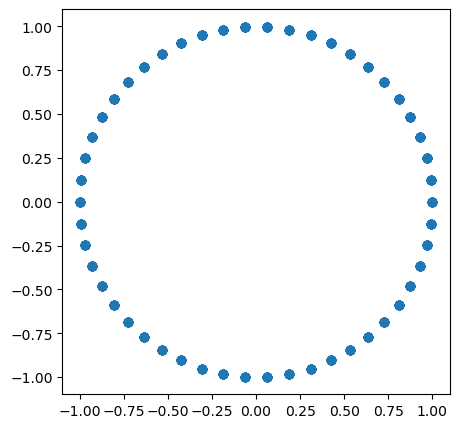

In [31]:
p = 5
m = 4

omega = nuCharacter(p, m, 10)

possibilities = [[]]
for i in range(m):
    new_possibilities = []
    for digs in possibilities:
        for k in range(p):
            new_digs = copy.deepcopy(digs)
            new_digs.append(k)
            new_possibilities.append(new_digs)
    possibilities = copy.deepcopy(new_possibilities)

X_coords = []
Y_coords = []
for digs in possibilities:
    z = p_Approx(p,0,digs)
    s = omega.eval(z)
    X_coords.append(s.real)
    Y_coords.append(s.imag)
    
plt.figure(figsize=(5,5))
plt.scatter(X_coords, Y_coords)
plt.show()

### Function: `Mellin`
**Input arguments:** (function, character)